### Visualise dynamics across global simulations - SP mode Atkin new vertical scaling scheme

In [1]:
#pip install panel
#pip install holoviews
#pip install hvplot

#### Libraries

In [2]:
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import panel as pn
import holoviews as hv
import hvplot.xarray
import functions_py.fates_xarray_functions as fa
import cartopy.crs as ccrs

#### Functions

In [3]:
def decay_coeff_kn(vcmax25top):
    ans = np.exp(0.00963 * vcmax25top - 2.43)
    return ans

#### Load FATES run

In [4]:
filename = '/compyfs/need138/elm_runs/spmode_atkin_mr_newvertprof.Ec63cce2-F5b372c9.2022-11-16/run/lnd/hist/spmode_atkin_mr_newvertprof.Ec63cce2-F5b372c9.2022-11-16.elm.h0.fullrun.nc'
fin= xr.open_dataset(filename)

fin['time'] = np.arange(len(fin['time']))

nyears = int(len(fin.variables['time'])/12)
tave_start = (nyears-5)*12
tave_stop = nyears*12

pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']


#### Calculate leaf construction cost per pft

In [5]:
# Leaf construction cost depends on cumulative LAI which corresponds to the leaf layer 
# dimension in CLLLPF. Therefore calculate leaf construction cost for each leaf layer and
# subtract from NET_C_UPTAKE_CLLLPF to get the full net C uptake. 

# PFT level parameters 
vcmax25top = [50, 34.9, 39, 61, 41, 35.83, 62, 54, 29.9, 78, 78, 78]
slatop = [0.012, 0.0099, 0.024, 0.009, 0.03, 0.023, 0.012, 0.03, 0.0078, 0.03, 0.03, 0.03]
slamax = [0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.0954, 0.012, 0.03, 0.03, 0.03, 0.03, 0.03]
root_long = [1, 2, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
leaf_long = [1.5, 4, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1, 1]
season_decid = [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]
stress_decid = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
grperc = [0.11, 0.092, 0.11, 0.11, 0.11, 0.15, 0.11, 0.11, 0.21, 0.11, 0.11, 0.11]

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')

# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
ds5 = fa.clllpf_to_cn_lf_by_pft(fin['FATES_NET_C_UPTAKE_CLLLPF'], fin, dataset2) 

leaf_costs = []

# This is kg C m-2 yr-1 (per unit ground area?)
for pf in range(0, len(pftnames)):
    
    pft_kn = decay_coeff_kn(vcmax25top[pf])
    nscaler_levleaf = np.exp(-pft_kn * leaf_layer_mids)  
    sla_levleaf = slatop[pf] / nscaler_levleaf
    m = [idx for idx in range(len(sla_levleaf)) if sla_levleaf[idx] > slamax[pf]]
    sla_levleaf[m] = slamax[pf]
    
    # if deciduous
    if(season_decid[pf] == 1) or (stress_decid[pf] == 1):
        # account for sla profile 
        leaf_cost = 1 / (sla_levleaf * 1000) 
        # growth respiration tax
        leaf_cost = (leaf_cost * (grperc[pf] + 1))
    
    # if evergreen    
    else : 
        leaf_cost = (1 / (sla_levleaf * 1000) * leaf_long[pf]) 
        leaf_cost = (leaf_cost * (grperc[pf] + 1)) 
    
    # now subtract this leaf cost from the relevant dimensions
    leaf_costs.append(leaf_cost)
    

#### Subtract leaf construction cost

In [6]:
leaf_costs = xr.DataArray(leaf_costs, dims = ['fates_levpft', 'fates_levleaf'])    

# Subtract leaf costs from net C uptake ( make net C uptake annual)
ds6 = (ds5 * 86400 * 365) - leaf_costs

# Now in kg C m-2 yr-1

print(ds6.shape)

(120, 12, 46, 72, 2, 36)


#### Average over time and remove empty canopy layers

In [7]:
# remove empty canopy layer
ds7 = ds6.isel(fates_levcan=0)

# sum over pfts
ds8 = ds7.sum(dim='fates_levpft')

# mean over time
ds8b = ds8.mean(dim='time')

print(ds8b.shape)

(46, 72, 36)


#### Divide by pft fraction

In [8]:
pft_frac = fin.FATES_NOCOMP_PATCHAREA_PF  # in m2 m-2

ds9 = ds7/pft_frac

# take average of time (we are only reading in the last 10 years of the simulation anyway)
ds9b = ds9.mean(dim='time')

print(ds9b.shape)

(12, 46, 72, 36)


#### Plot net C uptake by leaf layer for each PFT across the globe

In [9]:
image = ds8b.hvplot('lon', 'lat', cmap='coolwarm', width=600, clim=(-2,2))

stream = hv.streams.Tap(source=image, x=0, y=0)

@pn.depends(stream.param.x, stream.param.y)

def lainetc(x, y):
    return ds9b.sel(lon=x, lat=y, method='nearest').hvplot('fates_levleaf', width=600)

pn.Column(image, lainetc)

Column
    [0] Row
        [0] HoloViews(DynamicMap)
        [1] Column
            [0] WidgetBox
                [0] DiscreteSlider(margin=(20, 20, 20, 20), name='fates_levleaf', options=OrderedDict([('0.1705', ...]), value=0.17050000000000004, width=250)
            [1] VSpacer()
    [1] ParamFunction(function)

(12, 46, 72, 36)


''

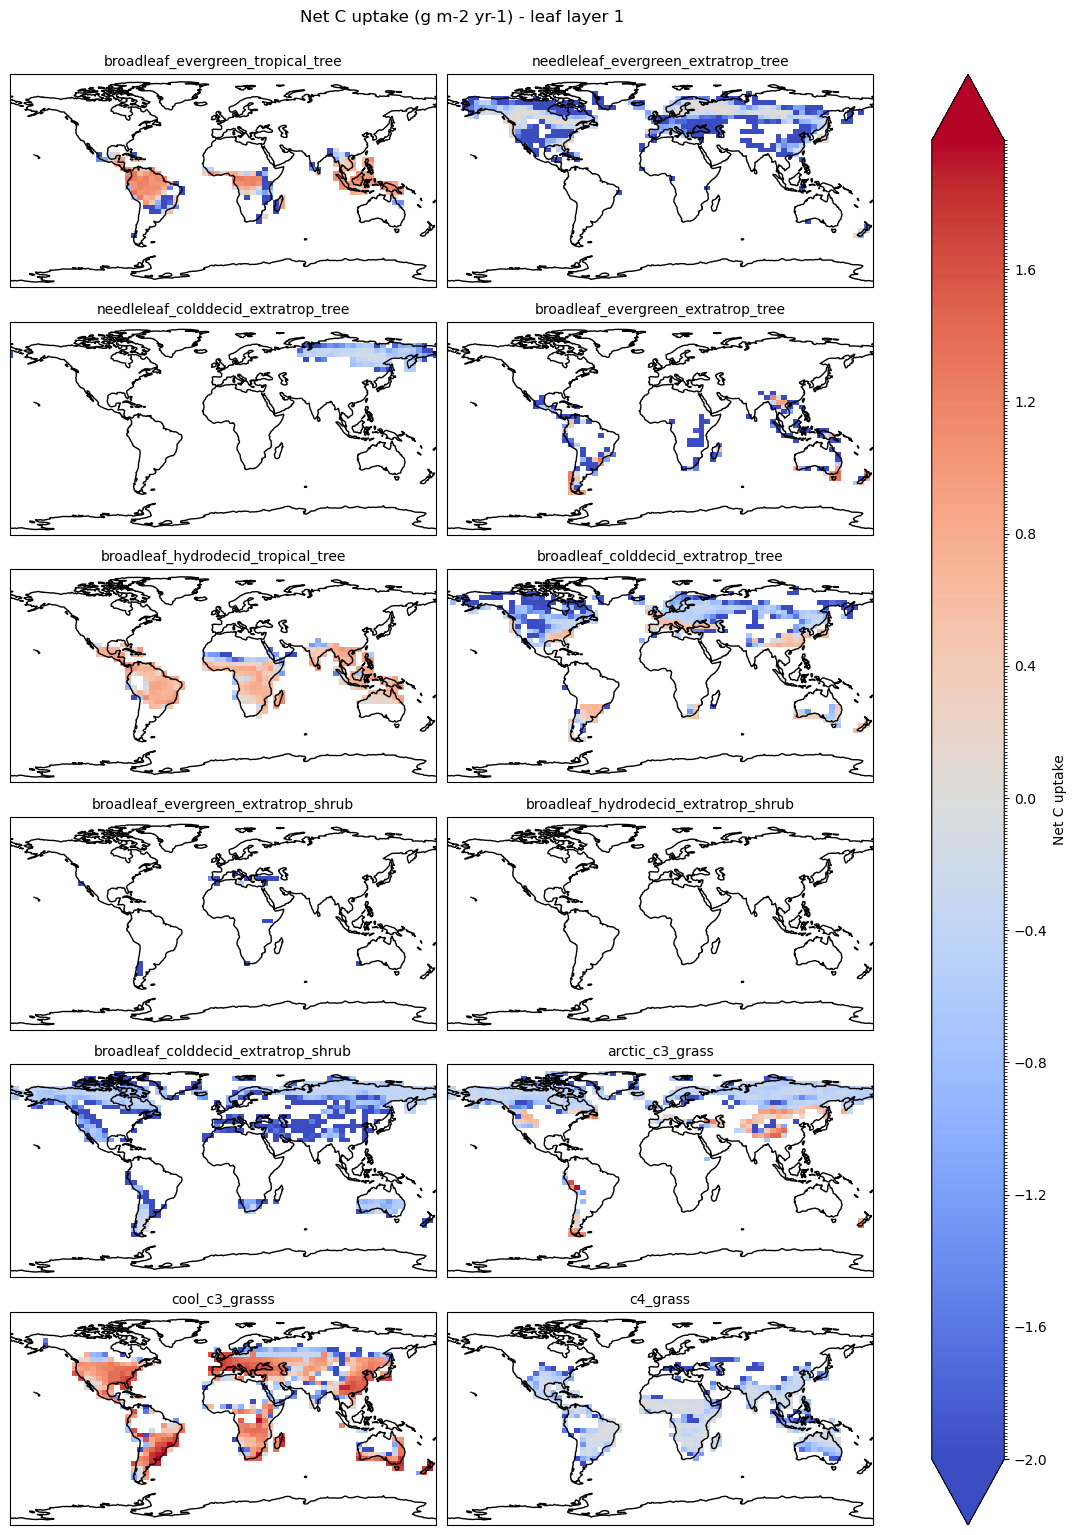

In [10]:
print(ds9b.shape)
ds10 = ds9b.isel(fates_levleaf=0)

g = ds10.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Net C uptake"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(-2,2,0.01), cmap='coolwarm',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Net C uptake (g m-2 yr-1) - leaf layer 1', y=1.02, x = 0.45)
;

''

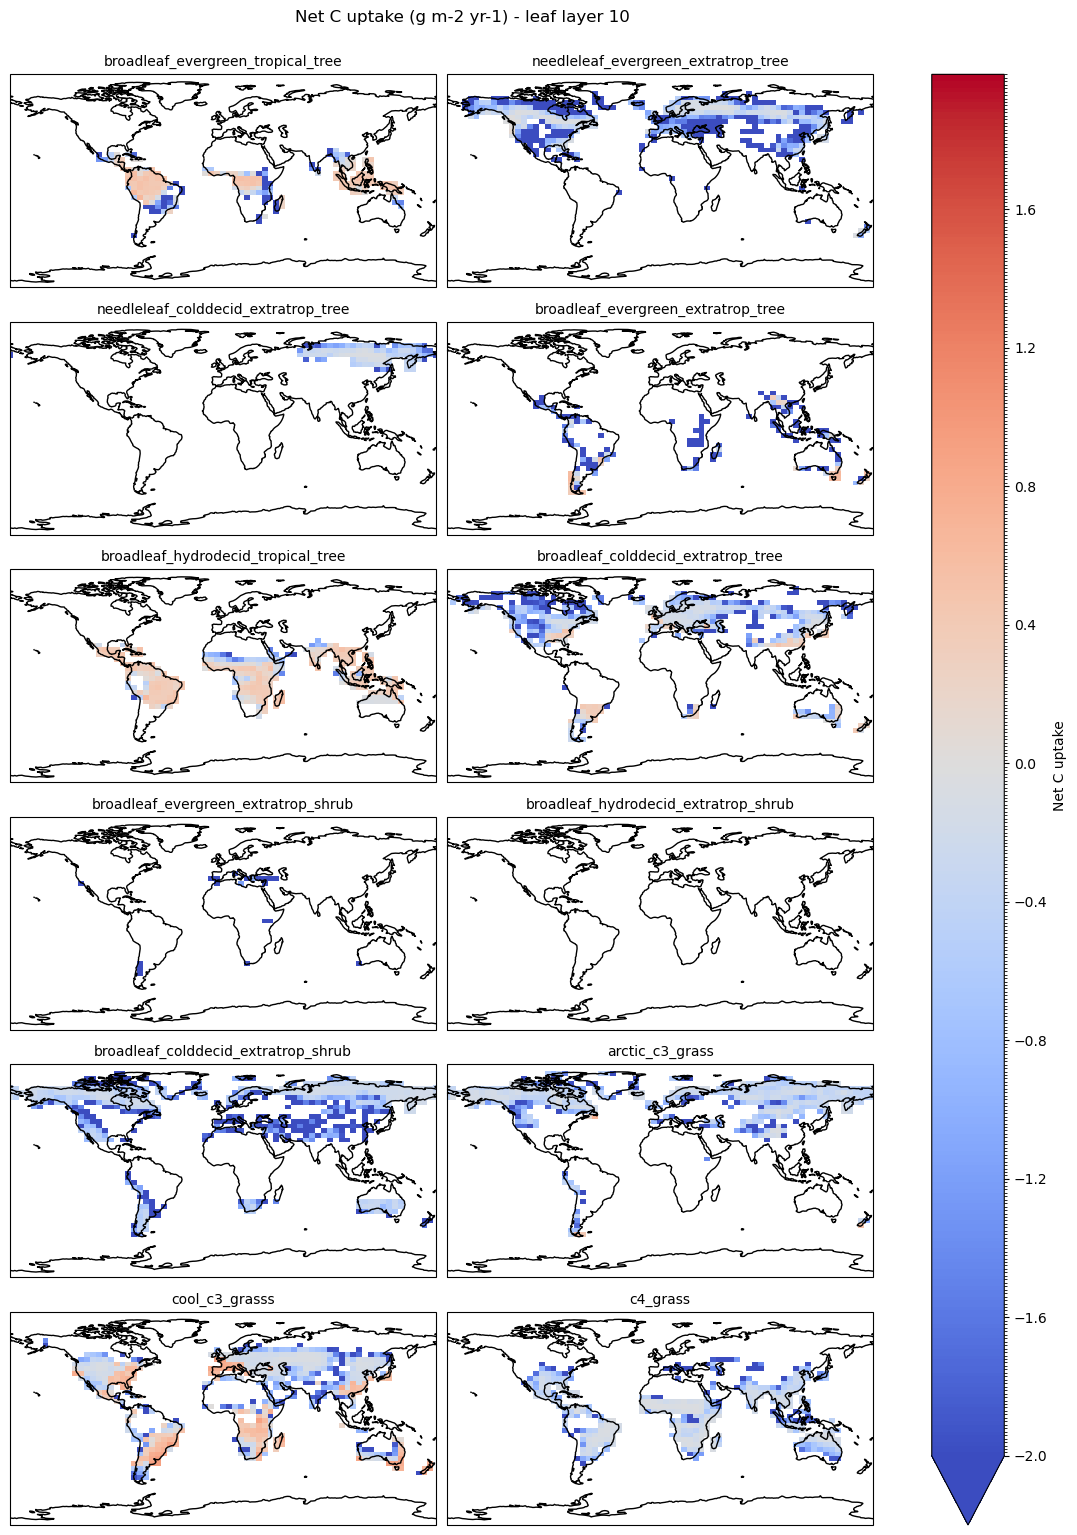

In [11]:
ds11 = ds9b.isel(fates_levleaf=9)

g = ds11.plot(x="lon",y="lat",col="fates_levpft", col_wrap=2, 
           figsize=(12, 15),
      cbar_kwargs={"label": "Net C uptake"},
      subplot_kws={"projection":ccrs.PlateCarree(),"facecolor":"white"},
          levels = np.arange(-2,2,0.01), cmap='coolwarm',
            facecolor="white")

for i, ax in enumerate(g.axes.flat):
    ax.set_title(pftnames[i], fontsize=10)

[ax.coastlines() for ax in g.axes.flatten()]

# Add a big title at the top
plt.suptitle('Net C uptake (g m-2 yr-1) - leaf layer 10', y=1.02, x = 0.45)
;